# Channel & Feature Importances For Hand-crafted features

In this tutorial, we show how to find channel and feature importances, using hand-crafted features on MedNIST data. First, let's download the data

In [1]:
import matplotlib.pyplot as plt
import glob
from imageio import imread
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import os
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

I only used 4000 samples

In [2]:
data_dir = './plasmodium/'
class_names = sorted([x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x))])
num_class = len(class_names)
image_files = [[os.path.join(data_dir, class_name, x) 
                for x in os.listdir(os.path.join(data_dir, class_name))] 
               for class_name in class_names]
image_file_list = []
image_label_list = []
for i, class_name in enumerate(class_names):
    image_file_list.extend(image_files[i])
    image_label_list.extend([i] * len(image_files[i]))


    
num_total = len(image_label_list)
image_width, image_height, channels = imread(image_file_list[0]).shape

print('Total image count:', num_total)
print("Image dimensions:", image_width, "x", image_height, "x", channels)
print("Label names:", class_names)



Total image count: 4000
Image dimensions: 133 x 124 x 3
Label names: ['Parasitized', 'Uninfected']


## Visualize randomly chosen pitures

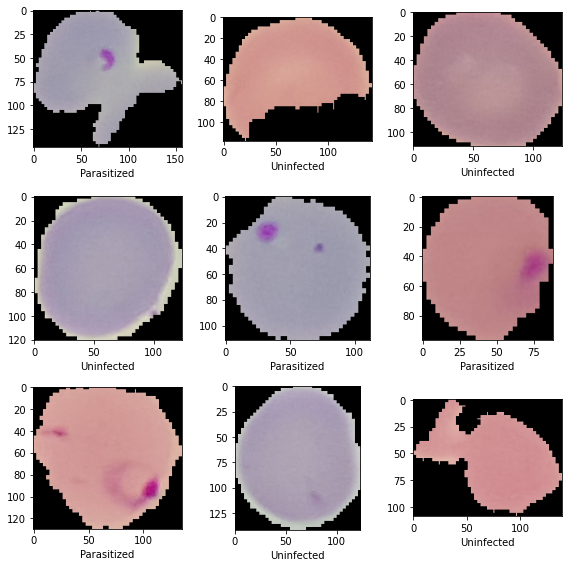

In [3]:
plt.subplots(3, 3, figsize=(8, 8))
for i,k in enumerate(np.random.randint(num_total, size=9)):
    im = imread(image_file_list[k])
    arr = np.array(im)
    plt.subplot(3, 3, i + 1)
    plt.xlabel(class_names[image_label_list[k]])
    plt.imshow(arr, cmap='gray', vmin=0, vmax=255)
plt.tight_layout()
plt.show()

as we see, we only have information in the Red channel, but green & blue are only noise.

In [4]:
import numpy as np
from scipy.stats import kurtosis, skew
from scipy.spatial import distance as dist
from skimage.feature import greycomatrix, greycoprops
from skimage.measure import shannon_entropy
from skimage.exposure import histogram
from skimage.measure import shannon_entropy
from skimage.measure import moments_hu, inertia_tensor, inertia_tensor_eigvals
from skimage.measure import moments
from skimage.measure import regionprops_table

def mask_based_features(image, mask):
    properties = ["area", 
              "bbox_area", 
              "convex_area", 
              "eccentricity", 
              "equivalent_diameter", 
              "euler_number", 
              "extent", 
              "filled_area", 
              "inertia_tensor",
              "inertia_tensor_eigvals",
              "major_axis_length", 
              "max_intensity",
              "mean_intensity",
              "min_intensity",
              "minor_axis_length", 
              "moments",
              "moments_central",
              "moments_hu",
              "moments_normalized",
              "orientation",
              "perimeter",
              "solidity"]
    feature_names = regionprops_table(mask[:,:,0].astype(int),
                                       image[:,:,0],
                                       properties = properties).keys()
    # storing the feature values
    features = dict()
    for ch in range(image.shape[2]):
        try:
            calculated_features = regionprops_table(mask[:,:,ch].astype(int), 
                                                        image[:,:,ch],
                                                        properties = properties)

            for p in feature_names:
                    features["mask_based_" +  p + "_Ch" + str(ch+1)] = calculated_features[p][0]
        except: 
            features["mask_based_" +  p + "_Ch" + str(ch+1)] = 0.
                
    return features

def basic_statistical_features(image):
    """calculates the set of basic statistical features 
    
    Calculates the standard statistical features per channel every 10th percentile,
    sum of the pixel values and different moments

    Parameters
    ----------
    image : 3D array, shape (M, N, C)
        The input image with multiple channels.

    Returns
    -------
    features :  dict  
        dictionary including percentiles, moments and sum per channel 

    """
    # storing the feature values
    features = dict()
    for ch in range(image.shape[2]):
        # percentiles
        features["min_intensity_Ch" + str(ch+1)] = image[:,:,ch].min()
        features["percentile10_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 10)
        features["percentile20_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 20)
        features["percentile30_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 30)
        features["percentile40_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 40)
        features["percentile50_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 50)
        features["percentile60_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 60)
        features["percentile70_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 70)
        features["percentile80_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 80)
        features["percentile90_intensity_Ch" + str(ch+1)] = np.percentile(image[:,:,ch] , 90)
        features["max_intensity_Ch" + str(ch+1)] = image[:,:,ch].max()

        # pixel sum
        features["total_intensity_Ch" + str(ch+1)] = image[:,:,ch].sum()

        # moments
        features["mean_intensity_Ch" + str(ch+1)] = image[:,:,ch].mean()
        features["std_intensity_Ch" + str(ch+1)] = image[:,:,ch].std()
        features["kurtosis_intensity_Ch" + str(ch+1)] = kurtosis(image[:,:,ch].ravel()) 
        features["skew_intensity_Ch" + str(ch+1)] = skew(image[:,:,ch].ravel()) 

        features["shannon_entropy_Ch" + str(ch+1)] = shannon_entropy(image[:,:,ch])
    
    return features




def glcm_features(image):
    """calculates the glcm features 
    
    Calculates the features per channel using glcm features including
    contrast, dissimilarity, homogeneity, ASM, energy and correlation.
    For more info please refer to:
    https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

    Parameters
    ----------
    image : 3D array, shape (M, N, C)
        The input image with multiple channels. 

    Returns
    -------
    features :  dict  
        dictionary including 'contrast_Chx', 'dissimilarity_Chx', 'homogeneity_Chx'
        'ASM_Chx', 'energy_Chx' and 'correlation_Chx' per channel where 
        x will be substituted by the channel number starting from 1. 

    """
    features = dict()
    for ch in range(image.shape[2]):
        # create a 2D temp image 
        temp_image = image[:,:,ch].copy()
        temp_image = (temp_image/temp_image.max())*255 # use 8bit pixel values for GLCM
        temp_image = temp_image.astype('uint8') # convert to unsigned for GLCM

        # calculating glcm
        glcm = greycomatrix(temp_image,distances=[5],angles=[0],levels=256)

        # storing the glcm values
        features["contrast_Ch" + str(ch+1)] = greycoprops(glcm, prop='contrast')[0,0]
        features["dissimilarity_Ch" + str(ch+1)] = greycoprops(glcm, prop='dissimilarity')[0,0]
        features["homogeneity_Ch" + str(ch+1)] = greycoprops(glcm, prop='homogeneity')[0,0]
        features["ASM_Ch" + str(ch+1)] = greycoprops(glcm, prop='ASM')[0,0]
        features["energy_Ch" + str(ch+1)] = greycoprops(glcm, prop='energy')[0,0]
        features["correlation_Ch" + str(ch+1)] = greycoprops(glcm, prop='correlation')[0,0]

    return features




preparing the features names

In [5]:

image = imread(image_file_list[0])
mask = (image[:,:,0] > 0).astype(int)
mask = np.stack([mask, mask, mask], axis = 2)
features = dict()
features.update(mask_based_features(image, mask))
features.update(basic_statistical_features(image))
features.update(glcm_features(image)) 



df_features = pd.DataFrame(columns=features,index = range(len(image_file_list)))


for faster results, you can parallelize this part

In [6]:
for i in tqdm(range(len(image_file_list))):
    image = imread(image_file_list[i])
    mask = (image[:,:,0] > 0).astype(int)
    mask = np.stack([mask, mask, mask], axis = 2)
    features = dict()
    features.update(mask_based_features(image, mask))
    features.update(basic_statistical_features(image))
    features.update(glcm_features(image)) 
    df_features.loc[i, :] = features
    features = None

100%|██████████| 4000/4000 [03:42<00:00, 17.98it/s]


In [7]:
df_features = df_features.dropna(axis = 1)

Now lets split the data to train and test, preprocess it and finally, use a Random Forest classifier

In [8]:
# Compare Algorithms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import VarianceThreshold

X_train, X_test, y_train, y_test = train_test_split( df_features.to_numpy(), image_label_list, test_size=0.25)


pipe = Pipeline([
      ('Scaler', MinMaxScaler()),
      ('LinearSVC', SelectFromModel(LinearSVC(penalty="l1", dual = False))),
      ('RandomForestClassifier', RandomForestClassifier())
])

param_grid = { 
    'LinearSVC__estimator__C': [0., 0.1, 0.5, 1., 1.5, 2., 5., 10., 20.],
    'RandomForestClassifier__max_features': ['auto', 'sqrt', 'log2'],
    'RandomForestClassifier__max_depth' : [3,4,5,6,7,8,10,15,20,50,100],
    'RandomForestClassifier__criterion' :['gini', 'entropy']
}

clf = GridSearchCV(pipe, param_grid, n_jobs=-1, cv= 5, verbose=2, scoring="f1_macro")
clf.fit(X_train, y_train)
 
print("Best parameter (CV score=%0.3f):" % clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 594 candidates, totalling 2970 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 317 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:   32.4s
[Parallel(n_jobs=-1)]: Done 965 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1937 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2970 out of 2970 | elapsed:  4.9min finished


Best parameter (CV score=0.954):
{'LinearSVC__estimator__C': 0.1, 'RandomForestClassifier__criterion': 'entropy', 'RandomForestClassifier__max_depth': 8, 'RandomForestClassifier__max_features': 'sqrt'}


In [9]:
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       507
           1       0.95      0.94      0.94       493

    accuracy                           0.94      1000
   macro avg       0.95      0.94      0.94      1000
weighted avg       0.95      0.94      0.94      1000



As you see, the quality of the prediction is pretty good. Now let's take a look at the top 20 important features

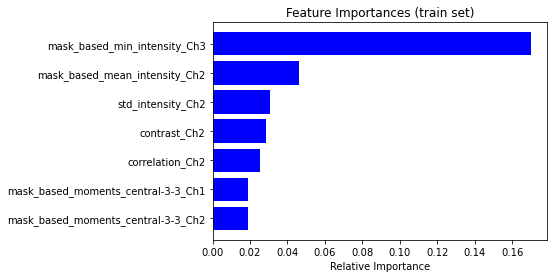

In [10]:
# get importance
importances = clf.best_estimator_[2].feature_importances_
cols = df_features.columns.values[clf.best_estimator_[1].get_support()]
indices = np.argsort(importances)[-20:-1]

plt.title('Feature Importances (train set)')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [cols[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()